<a href="https://colab.research.google.com/github/akshatsanghvi211103/DIP_Project/blob/main/dip_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import cv2
import numpy as np

def track_individual_pixels(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error opening video file")
        return

    # Read the first frame
    ret, prev_frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        print("Error reading video file")
        return

    # Convert the frame to grayscale
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    # Get the height and width of the frames
    height, width = prev_gray.shape

    # Number of pixels
    num_pixels = height * width

    # Create a dictionary to store the position of each pixel over time
    pixel_positions = {i: [] for i in range(1, num_pixels + 1)}

    frame_number = 1

    while True:
        # Read the next frame
        ret, frame = cap.read()

        # Break the loop if the video is finished
        if not ret:
            break

        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate optical flow using Lucas-Kanade method
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        # Get the x and y components of the flow
        flow_x = flow[..., 0]
        flow_y = flow[..., 1]

        # Flatten the flow components
        flat_flow_x = flow_x.flatten()
        flat_flow_y = flow_y.flatten()

        # Update the positions of each pixel
        for pixel_number in range(1, num_pixels + 1):
            # Get the coordinates of the pixel in the previous frame
            prev_pixel_x = (pixel_number - 1) % width
            prev_pixel_y = (pixel_number - 1) // width

            # Calculate the new coordinates based on optical flow
            new_pixel_x = int(prev_pixel_x + flat_flow_x[pixel_number - 1])
            new_pixel_y = int(prev_pixel_y + flat_flow_y[pixel_number - 1])

            # Append the new position to the list for the current pixel
            pixel_positions[pixel_number].append((new_pixel_x, new_pixel_y))

        # Update the previous frame
        prev_gray = gray

        # Increment the frame number
        frame_number += 1

    # Release the video capture object
    cap.release()
    return pixel_positions
    # Print the movement of a specific pixel (change the pixel_number variable accordingly)
    # pixel_number = 3
    # print(f"Movement of pixel {pixel_number}: {pixel_positions[pixel_number]}")

# Specify the path to the video file
video_path = './dataset/bobble_small.mp4'

# Call the function to track individual pixels
pixel_positions = track_individual_pixels(video_path)


In [28]:
import matplotlib.pyplot as plt

def plot_pixel_displacement(pixel_positions, pixel_number):
    # Get the x and y displacement for the given pixel
    x_displacement = np.array([pos[0] for pos in pixel_positions.get(pixel_number, [])])
    y_displacement = np.array([pos[1] for pos in pixel_positions.get(pixel_number, [])])
    print(x_displacement)

    # Plot the x and y displacement
    # plt.plot(x_displacement)
    plt.plot(y_displacement)

    # Add labels and legend
    # plt.ylabel('Displacement')
    plt.title(f'Displacement of Pixel {pixel_number}')
    plt.legend()

    # Show the plot
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[84 84 84 84 83 83 84 84 83 83 84 84 84 83 84 84 84 83 83 84 84 83 83 83
 84 84 83 82 84 85 84 82 82 85 86 84 81 82 85 86 83 81 82 85 86 83 81 83
 86 85 82 82 84 86 84 81 82 85 86 83 81 83 85 85 82 82 84 86 83 82 83 85
 85 82 82 83 86 84 82 82 85 86 83 81 83 85 85 82 82 84 86 84 81 82 85 85
 83 82 83 85 84 82 82 84 85 83 81 83 85 85 82 82 84 86 83 82 83 85 85 83
 82 83 85 84 82 82 84 85 84 82 83 85 85 83 82 84 85 84 82 82 84 85 83 82
 83 85 84 83 82 84 85 84 82 83 84 85 83 82 84]


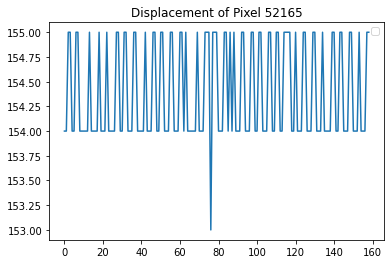

In [29]:
pixel_number = 85 + 155 * 336
plot_pixel_displacement(pixel_positions, pixel_number)
# print(f"Movement of pixel {pixel_number}: {pixel_positions[pixel_number]}")

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft


# Open the video file
cap = cv2.VideoCapture('./dataset/bobble_small.mp4')
frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
print(frames)
print(fps)

# Initialize previous frame
ret, prev_frame = cap.read()
prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
print(prev_frame_gray.shape)

# Create a HSV color image for visualizing the optical flow
hsv = np.zeros_like(prev_frame)
hsv[..., 1] = 255
hsv[..., 0] = 255
count = 0
disp = None
# curr = np.zeros((1, prev_frame_gray.shape[0], prev_frame_gray.shape[1], 2)
curr = None

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # cv2.imwrite('frame.jpg', frame)
    # break
    
    # Convert the current frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow
    flow = cv2.calcOpticalFlowFarneback(
        prev_frame_gray, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    if (disp is None):
        # disp = flow[np.newaxis, ...]
        curr = np.zeros((1, flow.shape[0], flow.shape[1], flow.shape[2]))
        disp = np.zeros((1, flow.shape[0], flow.shape[1], flow.shape[2]))
    else:
        curr = curr + flow[np.newaxis, ...] * (1 / fps)
        disp = np.concatenate([disp, curr], axis=0)

        
        
        

    # Calculate the magnitude and direction of the optical flow
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Update the previous frame
    prev_frame_gray = frame_gray
    if (count % 10 == 0):
      print(count)
    count += 1
    # if (count == 350):
    #     break


160.0
30.0
(416, 336)
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


33
0.20754716981132076


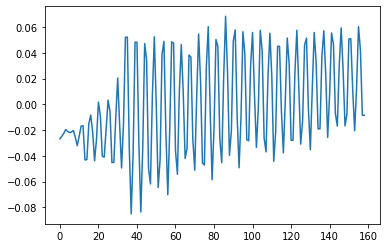

In [31]:
x = disp[:, 155, 85, 0] # this is reverse

x = x - np.mean(x)
plt.plot(x)
fft_result = np.fft.fft(x)
num_samples = x.shape[0]
frequencies = np.fft.fftfreq(num_samples)
magnitude = np.abs(fft_result)
# print(np.max(magnitude))
# plt.stem(frequencies, magnitude, 'b', markerfmt=" ", basefmt="-b")

max_freq_index = np.argsort(magnitude)[::-1][6]
print(max_freq_index)

max_freq = frequencies[max_freq_index]
print(max_freq)

plt.show()


34


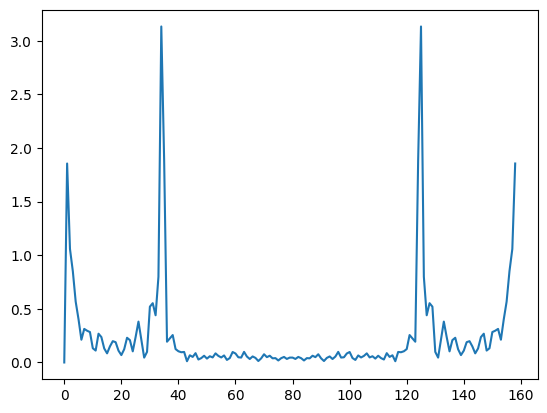

In [7]:
plt.plot(np.abs(fft_result))
print(np.argmax(np.abs(fft_result)))

plt.show()

(480, 848, 3)
35
0.22012578616352202
(49.98099760841062+26.342625825732043j)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


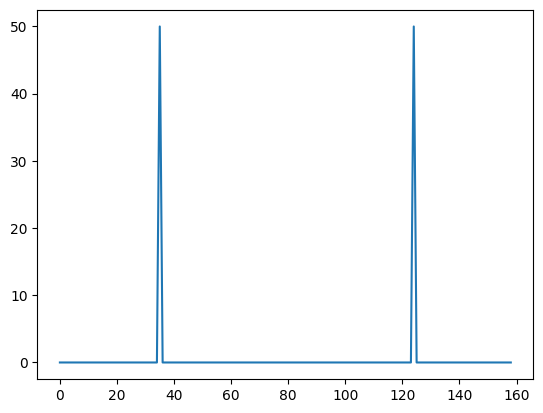

In [69]:
print(prev_frame.shape)
print(np.argmax(fft_result))
print(frequencies[35])
print(fft_result[35])
fft_result[fft_result < np.max(fft_result) - 0.1] = 0
plt.plot(fft_result)
plt.show()

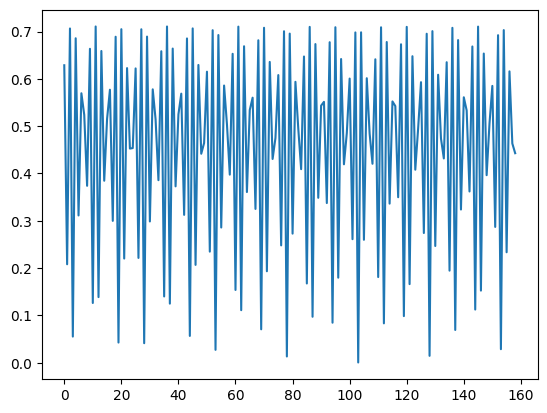

In [77]:
ifft = np.fft.ifft(fft_result)
plt.plot(np.abs(ifft))

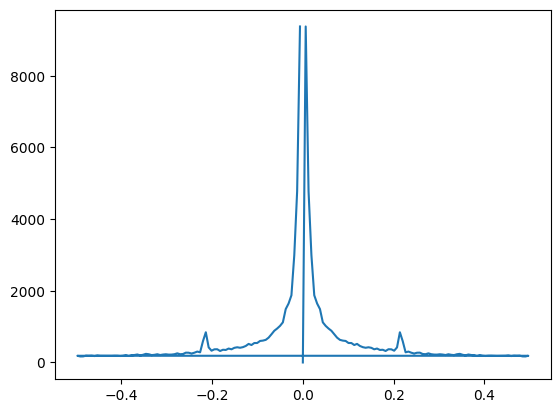

In [4]:
new_img = np.zeros_like(prev_frame)
new_img[:, :, 1] = 255
new_img[:, :, 0] = 255
freq_index = 35

fft_frequencies = None
T = disp.shape[0]
magnitude_sums = np.zeros(T)

for i in range(480):
  for j in range(848):
    x = disp[:, i, j, 0]
    x = x - np.mean(x)
    # plt.plot(x)
    fft_result = np.fft.fft(x)
    num_samples = x.shape[0]
    frequencies = np.fft.fftfreq(num_samples)
    magnitude = np.abs(fft_result)

    fft_frequencies = frequencies
    magnitude_sums += magnitude

    max_magnitude = magnitude[freq_index]

    angle = np.angle(fft_result)[freq_index]
    new_img[i, j, 0] = angle
    new_img[i, j, 2] = max_magnitude

magnitude_sums /= T
plt.plot(fft_frequencies, magnitude_sums)


new_img[:, :, 2] = cv2.normalize(new_img[:, :, 2], None, 0, 255, cv2.NORM_MINMAX)
flow_rgb = cv2.cvtColor(new_img, cv2.COLOR_HSV2BGR)

# plt.imshow(flow_rgb)
plt.show()


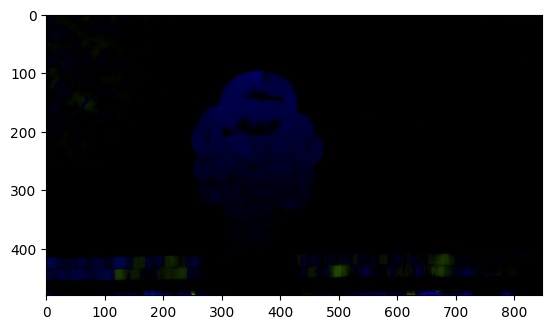

In [57]:
plt.imshow(flow_rgb)

In [58]:
index = np.argsort(magnitude_sums)[::-1]
main_index = 0
count = 0
for i in range(1, index.shape[0] - 1):
  if ((magnitude_sums[i] > magnitude_sums[i - 1]) & (magnitude_sums[i] > magnitude_sums[i + 1])):
    main_index = i
    count += 1

  if count > 3:
    break

print(main_index)
print()
print(fft_frequencies[main_index])
print()
print(magnitude_sums[main_index])

26

0.16352201257861637

11659.448015597949


In [5]:
w_index = 35
best_mode = []
for i in range(480):
  for j in range(848):
    x = disp[:, i, j, 0]
    x = x - np.mean(x)
    # plt.plot(x)
    fft_result = np.fft.fft(x)
    best_mode.append(fft_result[w_index])

best_mode = np.array(best_mode)

In [3]:
hyp = {'amplification' : 1, 'time' : 160, 'mass' : 1, 'damp' : 0.095}

In [10]:
e = np.zeros(20)
e[0] = np.array([0, 0])


ValueError: setting an array element with a sequence.

Using their modal coordinate equation

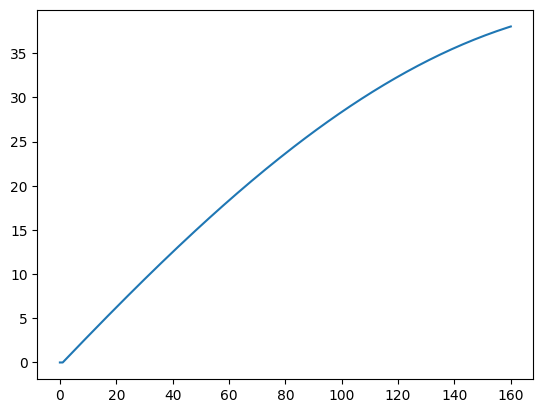

In [35]:
def calcDisplacment(hyp, freq, pixel, force):
    '''
    hyp is the dictionary having the hyperparameters
    freq is the user defined frequency of the mode shape
    pixel is the point of application of force
    force is the 2D vector correponding to the force applied by the user
    '''
    alpha = hyp.amplification # Amplification factor
    f_x = force[0] * np.abs(best_mode[pixel[0] * hyp.width + pixel[1]]) # The force in the modal coordinates
    f_y = force[1] * np.abs(best_mode[pixel[0] * hyp.width + pixel[1]]) # The force in the modal coordinates

    t = hyp.time # The total time of the simulation
    x = np.zeros((t + 1)) # The array corresponding to the output displacement in the x dirn
    y = np.zeros((t + 1)) # The array corresponding to the output displacement in the y dirn
    dt = 1 / fps # we had assumed time stamp is 1 in the x+vt
    d = hyp.damp # damping factor
    m = hyp.mass

    for i in range(t):
        # m1 = np.array([[1, h], [-w**2 * h, 1 - 2*d*w*h]])
        # m2 = np.array([0, h/m])
        # Numerically unstable code

        # if(i != 0):
        #   f = 0
        # y[i + 1] = (m1 @ y[i].T)
        # y[i + 1] = y[i + 1].T
        
        # Numerically Stable Formula
        x[i + 1] = (f_x / (freq * m)) * (np.e ** (- d * freq * i * dt)) * np.sin(freq * i * dt) # The actual displacement
        y[i + 1] = (f_y / (freq * m)) * (np.e ** (- d * freq * i * dt)) * np.sin(freq * i * dt) # The actual displacement
    return x, y


Finding phi (modal matrix)

In [9]:
plt.plot(np.abs(np.fft.fft(y[:, 0])))
print(np.argmax(np.abs(np.fft.fft(y[:, 0]))))
print(frequencies[3])
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [26]:
final_destination = np.zeros((t, 480*848))

for i in range(t):
  q = np.complex128(y[i])
  final_destination[i, :] = (q * best_mode).real

print(final_destination.shape)

(160, 407040)


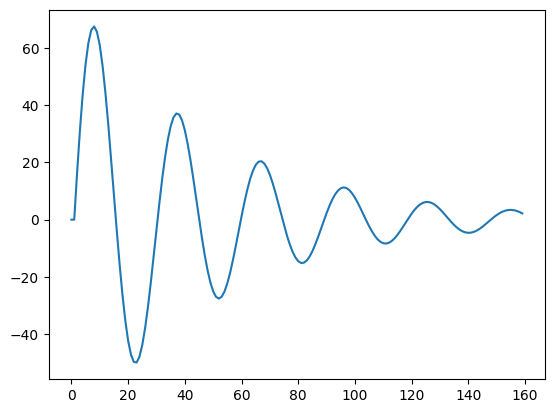

In [27]:
p2 = [215, 260]
ans = final_destination[:, p2[0] * 848 + p2[1]]
plt.plot(ans)

In [28]:
print(final_destination.shape)
final_destination = final_destination / 5

(160, 407040)


In [29]:
frame = cv2.imread('frame.jpg')

In [31]:
# inpainting_mask = np.zeros_like(frame, dtype=np.uint8)
inpainting_mask = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)

# Initialize the current frame with the initial frame
current_frame = frame.copy()
video_frames = []
# Loop through each frame
for frame_idx in range(200):
    flow_data_x = final_destination[frame_idx]  # X-direction flow data for the current frame

    # Loop through each pixel's optical flow in the current frame
    for y in range(480):
        for x in range(848):
            flow_x = flow_data_x[y * 848 + x]
            new_x = int(x + flow_x)

            # Check if the new x-coordinate is within the frame
            if 0 <= new_x < current_frame.shape[0]:
                # Apply optical flow to the pixel
                current_frame[y, new_x] = frame[y, x]
            else:
                # Mark the pixel for inpainting (out of frame)
                inpainting_mask[y, x] = 255  # Set to white

    # Perform inpainting on the current frame to fill gaps
    inpainting_radius = 5  # Adjust the radius as needed
    current_frame = cv2.inpaint(current_frame, inpainting_mask, inpainting_radius, cv2.INPAINT_TELEA)
    video_frames.append(current_frame)

    # Display or save the current frame
    cv2.imshow('Inpainting Result', current_frame)
    cv2.waitKey(1)  # Adjust the delay between frames as needed (ms)

cv2.destroyAllWindows()


KeyboardInterrupt: 

In [12]:
# converting all the frames to a video
height, width, layers = video_frames[0].shape
size = (width, height)
out = cv2.VideoWriter('project_y.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
for i in range(len(video_frames)):
    out.write(video_frames[i])
out.release()
